In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import json

In [2]:
working_dir = os.getcwd()
print(f"You are now working in {working_dir}")
print("If you need to change to the parent directory, run the cell below")

You are now working in c:\Users\fredd\Desktop\Studier\Project5\flowers\flowers_CNN\jupyter_notebooks
If you need to change to the parent directory, run the cell below


In [3]:
os.chdir(os.path.dirname(working_dir))

In [4]:
working_dir = os.getcwd()
print(f"You have now changed your working directory to {working_dir}")

You have now changed your working directory to c:\Users\fredd\Desktop\Studier\Project5\flowers\flowers_CNN


In [5]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(working_dir) and version in os.listdir(working_dir + '/outputs'):
    print("This version already exists, create a new version if you are working on a new version")
    pass
else:
    os.makedirs(name=file_path)

This version already exists, create a new version if you are working on a new version


In [6]:
image_dirs = 'inputs/dataset/raw/flower_photos'
train_path = image_dirs + '/train'
val_path = image_dirs + '/validation'
test_path = image_dirs + '/test'

In [7]:
labels = os.listdir(train_path)

print(f"Flower labels: {labels}")

Flower labels: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


* train - daisy: 3544 images
* train - dandelion: 5028 images
* train - roses: 3589 images
* train - sunflowers: 3914 images
* train - tulips: 4474 images
* validation - daisy: 506 images
* validation - dandelion: 718 images
* validation - roses: 512 images
* validation - sunflowers: 559 images
* validation - tulips: 639 images
* test - daisy: 1014 images
* test - dandelion: 1438 images
* test - roses: 1027 images
* test - sunflowers: 1119 images
* test - tulips: 1279 images




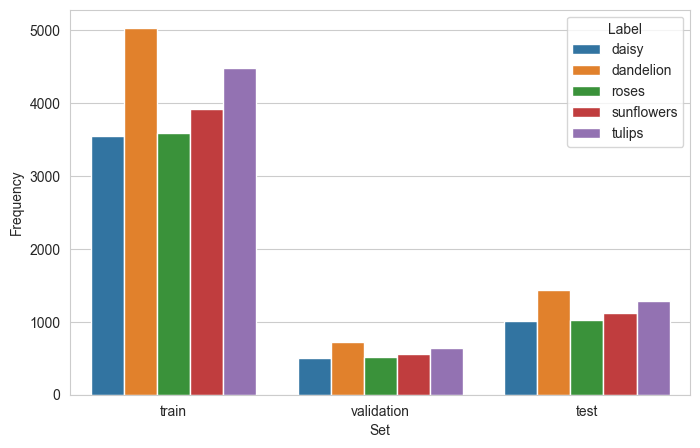

In [8]:
data = []


for folder in ['train', 'validation', 'test']:
    for label in labels:
        
        data.append({
            'Set': folder,
            'Label': label,
            'Frequency': int(len(os.listdir(image_dirs + '/' + folder + '/' + label)))
        })
        
        print(f"* {folder} - {label}: {len(os.listdir(image_dirs + '/' + folder + '/' + label))} images")


df_freq = pd.DataFrame(data)


print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

In [21]:


class ImageClassificationPipeline:
    def __init__(self, train_path, val_path, test_path, input_shape=(224, 224, 3), batch_size=20, num_classes=5):
        self.train_path = train_path
        self.val_path = val_path
        self.test_path = test_path
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.num_classes = num_classes

        # Initialize ImageDataGenerators
        self.train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.10,
            height_shift_range=0.10,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
        )
        self.val_test_datagen = ImageDataGenerator(rescale=1./255)

        # Build data generators
        self.train_set = self.train_datagen.flow_from_directory(
            self.train_path, target_size=self.input_shape[:2], batch_size=self.batch_size,
            class_mode='categorical', shuffle=True
        )
        self.validation_set = self.val_test_datagen.flow_from_directory(
            self.val_path, target_size=self.input_shape[:2], batch_size=self.batch_size,
            class_mode='categorical', shuffle=False
        )
        self.test_set = self.val_test_datagen.flow_from_directory(
            self.test_path, target_size=self.input_shape[:2], batch_size=self.batch_size,
            class_mode='categorical', shuffle=False
        )
        
        # Retrieve label map
        self.label_map = list(self.train_set.class_indices.keys())
        
        # Build model
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])
        
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def train(self, epochs=25, early_stopping_patience=3):
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
        
        self.history = self.model.fit(
            self.train_set,
            validation_data=self.validation_set,
            epochs=epochs,
            callbacks=[early_stop],
            verbose=1
        )

    def evaluate(self, savepath=None): 
        y_pred_probs = self.model.predict(self.test_set)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = self.test_set.classes

        # Calculate F1 score
        f1 = f1_score(y_true, y_pred, average='weighted')
        print(f"F1 Score (weighted): {f1:.4f}")

        # Classification report
        report = classification_report(y_true, y_pred, target_names=self.label_map, output_dict=True)
        print("\nClassification Report:")
        print(report)

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.label_map)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        # If savepath is given, save JSON-file
        if savepath:
            evaluation_data = {
                "f1_score_weighted": f1,
                "classification_report": report,
                "confusion_matrix": cm.tolist()  # Converts numpy array to list for JSON-file
            }

            # Saves data as JSON-file
            with open(savepath, 'w') as f:
                json.dump(evaluation_data, f, indent=4)
            print(f"Evaluation saved as {savepath}")

    def plot_training_history(self, savepath):
        plt.figure(figsize=(12, 5))
        
        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.tight_layout()
        plt.savefig(savepath, bbox_inches='tight', dpi=150)
        plt.show()





In [10]:
pipeline = ImageClassificationPipeline(train_path, val_path, test_path)
pipeline.train(epochs=25)


Found 20549 images belonging to 5 classes.
Found 2934 images belonging to 5 classes.
Found 5877 images belonging to 5 classes.


C:\Users\fredd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\fredd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 596s 577ms/step - accuracy: 0.4563 - loss: 1.2909 - val_accuracy: 0.6230 - val_loss: 0.9462
Epoch 2/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 592s 576ms/step - accuracy: 0.6690 - loss: 0.8663 - val_accuracy: 0.7154 - val_loss: 0.7330
Epoch 3/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 595s 578ms/step - accuracy: 0.6995 - loss: 0.7909 - val_accuracy: 0.7410 - val_loss: 0.6590
Epoch 4/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 594s 577ms/step - accuracy: 0.7189 - loss: 0.7397 - val_accuracy: 0.7631 - val_loss: 0.6059
Epoch 5/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 598s 581ms/step - accuracy: 0.7340 - loss: 0.6909 - val_accuracy: 0.7597 - val_loss: 0.6273
Epoch 6/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 625s 608ms/step - accuracy: 0.7545 - loss: 0.6507 - val_accuracy: 0.7662 - val_loss: 0.5859
Epoch 7/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 598s 581ms/step - accuracy: 0.7616 - loss: 0.6298 - val_accuracy: 0.7866 - val_loss: 0.5448
Epoch 8/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 594s 578ms/step - ac

In [22]:
pipeline.evaluate(savepath=f"{file_path}/model_evaluation.json")


TypeError: ImageClassificationPipeline.evaluate() got an unexpected keyword argument 'savepath'

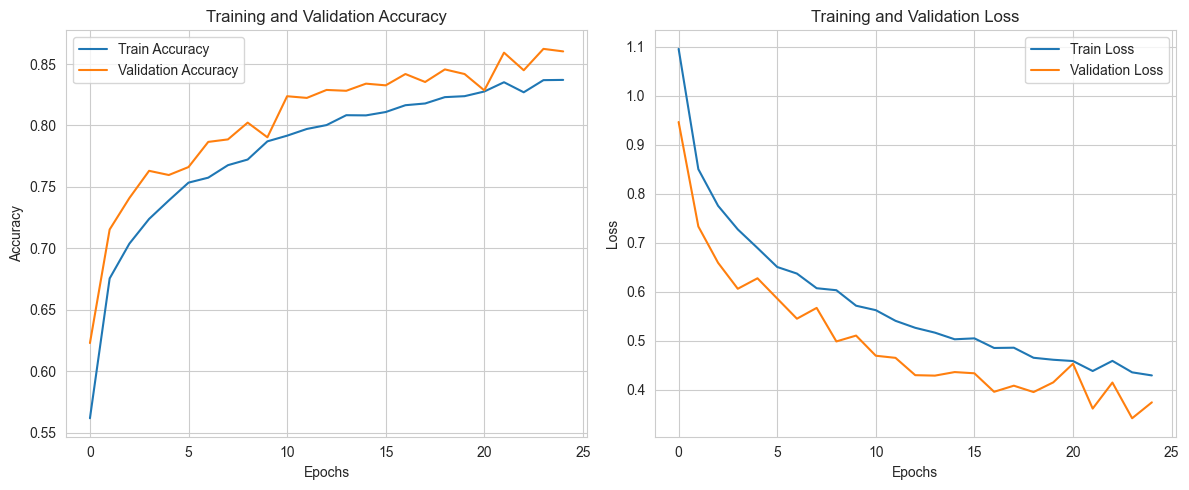

In [ ]:
pipeline.plot_training_history(savepath=f"{file_path}/training_history.png")